```
This software is a part of GPU Ocean.

Copyright (C) 2019, 2020  SINTEF Digital

Investigating algorithms to define local regions for proccessing by
the LETKF algorithm.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Local regions for LETKF


## Set environment

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pycuda.driver as cuda
import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation, DoubleJetCase

In [ ]:
%cuda_context_handler gpu_ctx

### The data path
Loading the true state used in the Double Jet experiments

In [ ]:
truth_path = os.path.abspath('../papers/DAPaper/presented_data/true_state/')

In [ ]:
os.listdir(truth_path)

['double_jet_case_truth.nc', 'drifter_observations.pickle', 'info.txt']

### Define functions for plotting

In [ ]:
def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12.5,3.4), interior=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
    
    range_eta = np.max(np.abs(eta))
    range_huv = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    range_eta = 3.5
    range_huv = 625
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    
def plotDrifters(observations, sim_reader, t, drifter_set=[], field_data=None, drifter_set_only=True):
    drifter_positions = observations.get_drifter_position(t)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')

    if field_data is None:
        emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
        ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')
    else:
        ax.imshow(field_data, origin="lower", extent=[0, nx*dx, 0, ny*dy])
        
    for i in range(drifter_positions.shape[0]):
        color = 'xkcd:pale cyan'
        if i in drifter_set:
            color = 'xkcd:tomato red'
        elif drifter_set_only:
            continue
        circ_end = matplotlib.patches.Circle((drifter_positions[i,0], drifter_positions[i,1]),
                                             3000, fill=True, zorder=10, color=color)
        ax.add_patch(circ_end)
        
def plotDriftersOnField(observations, sim_reader, t, drifter_set=[]):
    drifter_positions = observations.get_drifter_position(t)
    

    
def days_to_sec(days):
    return days*24*60*60

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

# The double jet steady state

In [ ]:
truth_state_filename = os.path.join(truth_path, "double_jet_case_truth.nc")
observations_filename = os.path.join(truth_path, "drifter_observations.pickle")

truth_reader = SimReader.SimNetCDFReader(truth_state_filename)
observations = Observation.Observation()
observations.read_pickle(observations_filename)

## Plot initial state (day 3)

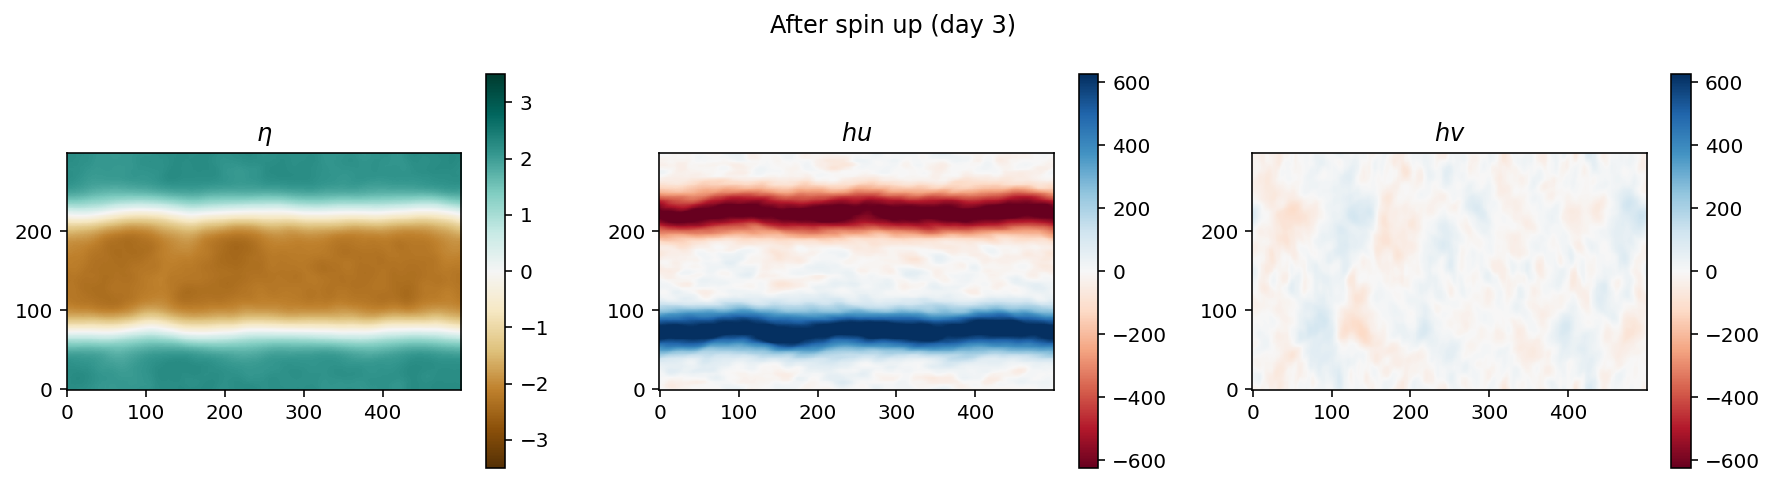

In [ ]:
day = 3
title = "After spin up"
title = title + " (day " + str(day) + ")"
t = days_to_sec(day)
t_index = truth_time_step(t)
eta, hu, hv, t = truth_reader.getTimeStep(t_index)
imshow3(eta, hu, hv, title=title)

# Initial drifters


In [ ]:
drifter_set = np.arange(0, 64, 7)
drifter_set = np.array([ 2,  7, 12, 24, 29, 35, 41, 48, 53, 60])
print(len(drifter_set))
print(drifter_set)

10
[ 2  7 12 24 29 35 41 48 53 60]


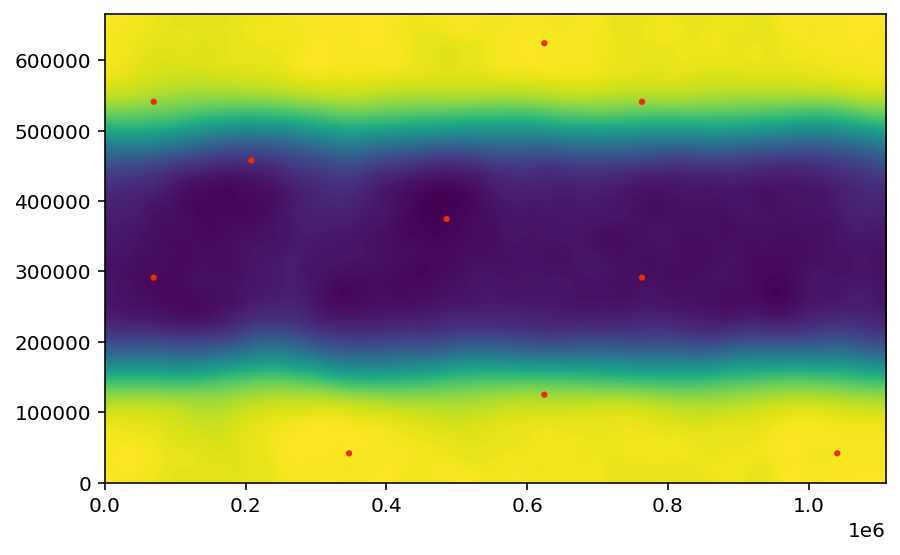

In [ ]:
t_spinup = days_to_sec(3)
plotDrifters(observations, truth_reader, t_spinup, drifter_set, eta)



# Distance measure

[485625. 374625.]
[  1110. 374625.] [1108890.  374625.] 2220.0 1110000.0 500


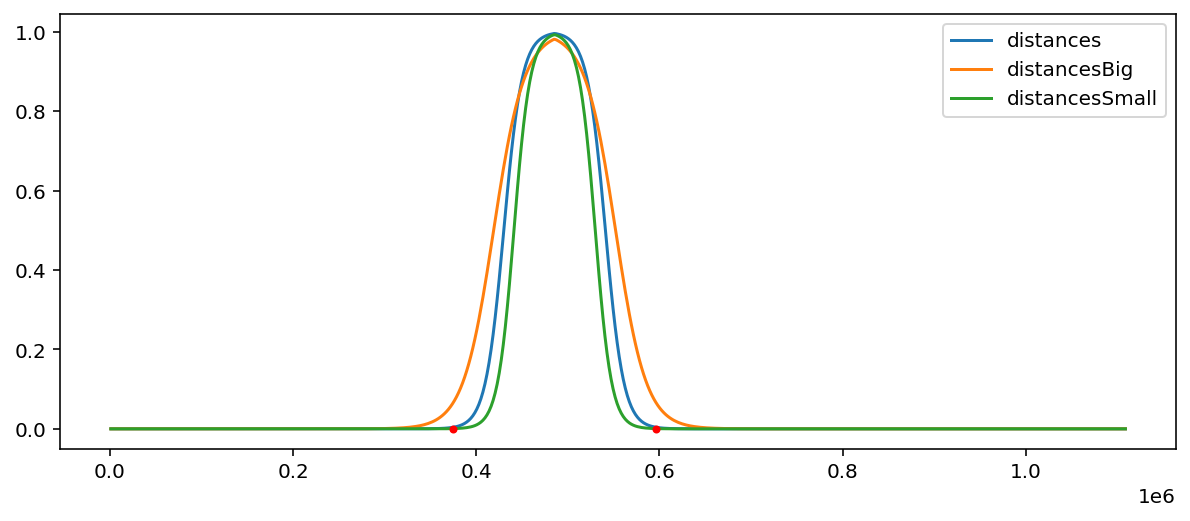

In [ ]:
def dist(obs, loc, r, slope_factor, lx, ly):
    if not obs.shape == loc.shape: 
        obs = np.tile(obs, (loc.shape[0],1))
    
    if len(loc.shape) == 1:
        dist = min(np.linalg.norm(np.abs(obs-loc)),
                   np.linalg.norm(np.abs(obs-loc) - np.array([lx,0 ])),
                   np.linalg.norm(np.abs(obs-loc) - np.array([0 ,ly])),
                   np.linalg.norm(np.abs(obs-loc) - np.array([lx,ly])) )
    else:
        dist = np.linalg.norm(obs-loc, axis=1)
    
    return 1 - (1 + np.tanh((dist-r)/slope_factor))/2

def boxDist(obs, loc, lx, ly):
    return min(np.max(np.abs(obs-loc)),
               np.max(np.abs(np.abs(obs-loc)-np.array([lx,0 ]))),
               np.max(np.abs(np.abs(obs-loc)-np.array([0 ,ly]))),
               np.max(np.abs(np.abs(obs-loc)-np.array([lx,ly]))))

def getLocalBox(obs, sim_reader, r):
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')
    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    lx = dx*nx
    ly = dy*ny
    box_field = np.zeros((ny, nx))
    for j in range(ny):
        for i in range(nx):
            loc = np.array([(i+0.5)*dx, (j+0.5)*dy])
            if boxDist(obs, loc, lx, ly) < r*2:
                box_field[j, i] = 1
    return box_field

def distField(obs, sim_reader, r, slope_factor):
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')
    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    lx = dx*nx
    ly = dy*ny
    dist_field = np.zeros((ny, nx))
    for j in range(ny):
        for i in range(nx):
            loc = np.array([(i+0.5)*dx, (j+0.5)*dy])
            dist_field[j, i] = dist(obs, loc, r, slope_factor, lx, ly)
    return dist_field
            

    
drifter_positions = observations.get_drifter_position(t)
dx = truth_reader.get('dx')
nx = truth_reader.get('nx')

obs = drifter_positions[drifter_set[5],:]
print(obs)

locs = np.zeros((nx, 2))
locs[:, 0] = np.linspace(dx/2, nx*dx-dx/2, nx)
locs[:, 1] = obs[1]
print(locs[0,:], locs[-1, :], dx, dx*nx, nx)

distances = dist(obs, locs, dx*25, dx*9, 0, 0)
distancesBig = dist(obs, locs, dx*30, dx*15, 0, 0)
distancesSmall = dist(obs, locs, dx*20, dx*8, 0, 0)

fig = plt.figure(figsize=(10,4))
plt.plot(locs[:,0], distances, label='distances')
plt.plot(locs[:,0], distancesBig, label='distancesBig' )
plt.plot(locs[:,0], distancesSmall, label='distancesSmall')
plt.legend()

plt.plot([obs[0]-dx*25*2, obs[0]+dx*25*2], [0, 0], 'r.')


In [ ]:
r_factor = 20
drop_factor = 8

dist_field = distField(obs, truth_reader, dx*r_factor, dx*drop_factor)
box_field = getLocalBox(obs, truth_reader, dx*((r_factor/2)+drop_factor))
print(dist_field.shape)

(300, 500)


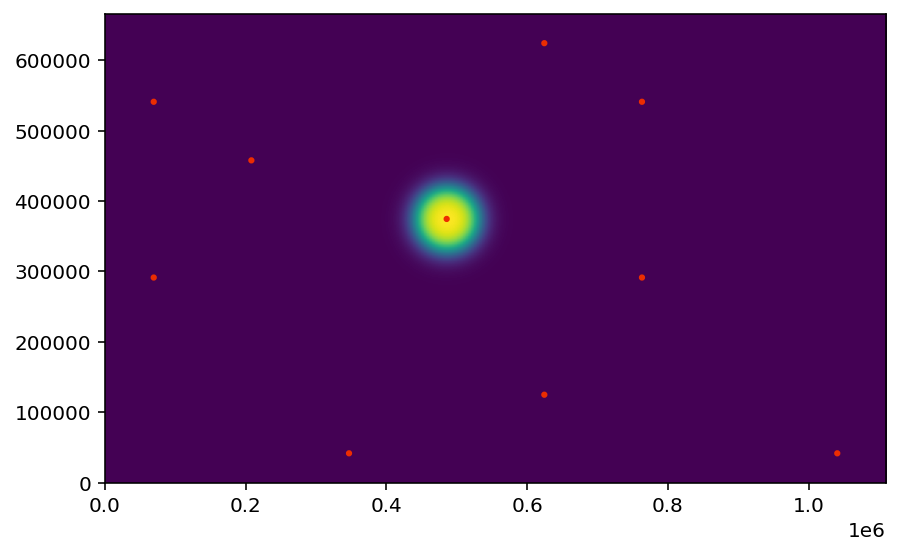

In [ ]:
plotDrifters(observations, truth_reader, t_spinup, drifter_set, dist_field)

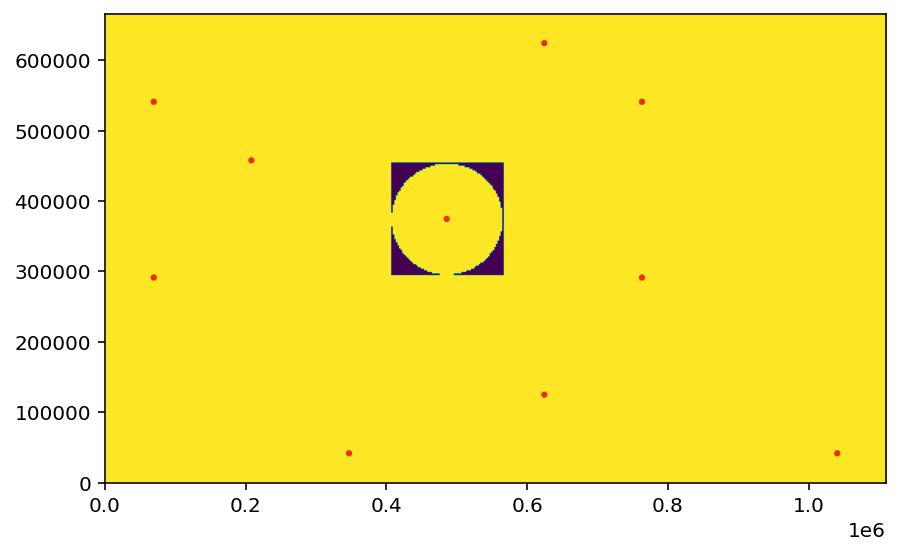

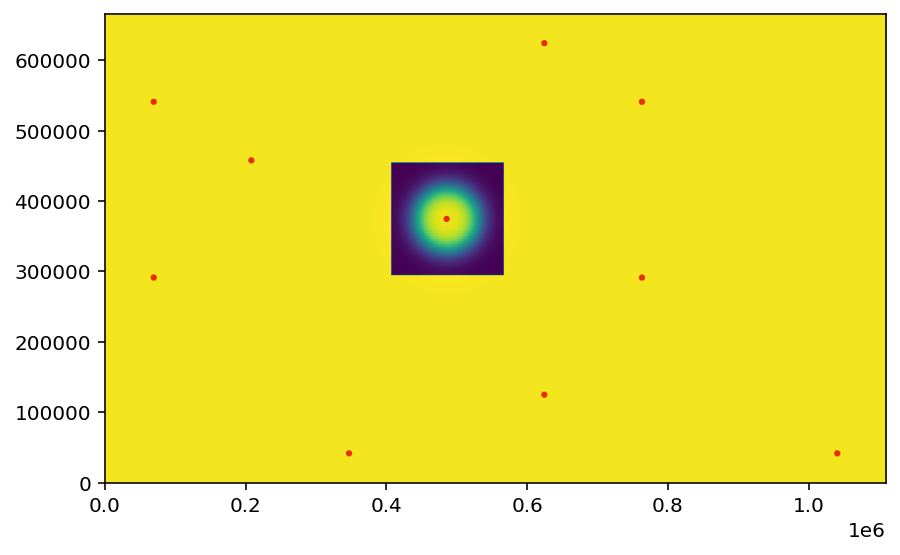

In [ ]:
cutoff_field = dist_field > 0.02
plotDrifters(observations, truth_reader, t_spinup, drifter_set, -box_field+cutoff_field)
plotDrifters(observations, truth_reader, t_spinup, drifter_set, -box_field+dist_field)


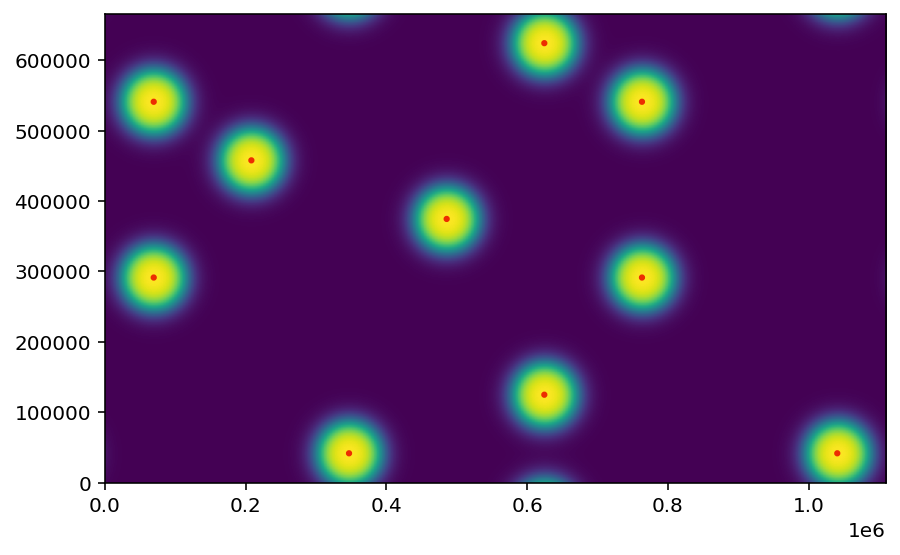

In [ ]:
# Warning: SLOW
dist_field_all = distField(drifter_positions[drifter_set[0],:], truth_reader, dx*r_factor, dx*drop_factor)
for d in range(1,10):
    dist_field_all += distField(drifter_positions[drifter_set[d],:], truth_reader, dx*r_factor, dx*drop_factor)


In [ ]:
# Warning: SLOW
box_field_all = getLocalBox(drifter_positions[drifter_set[0],:], truth_reader, dx*((r_factor/2)+drop_factor))
for d in range(1,10):
    box_field_all += getLocalBox(drifter_positions[drifter_set[d],:], truth_reader, dx*((r_factor/2)+drop_factor))


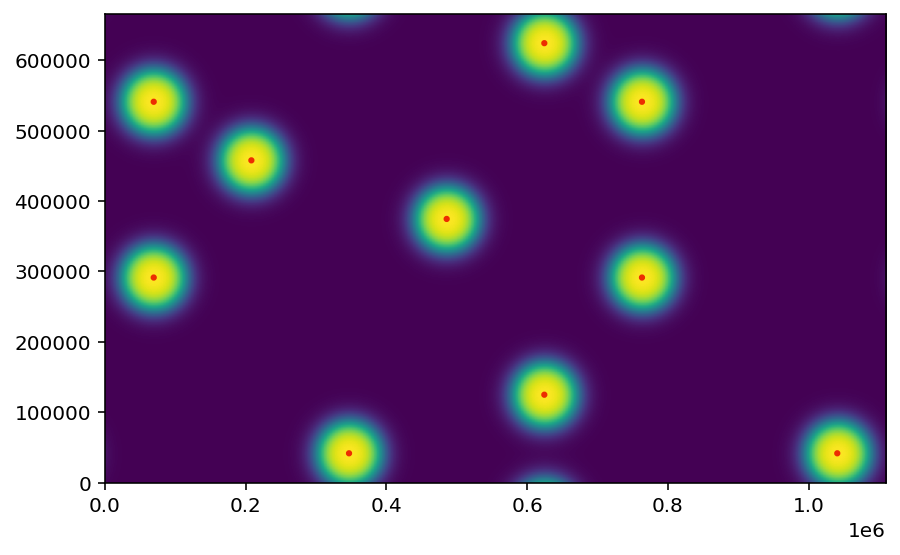

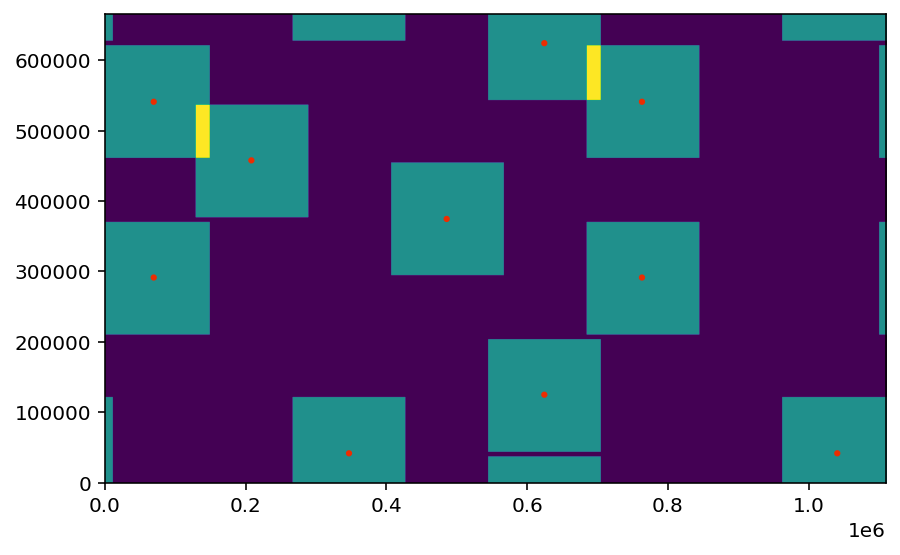

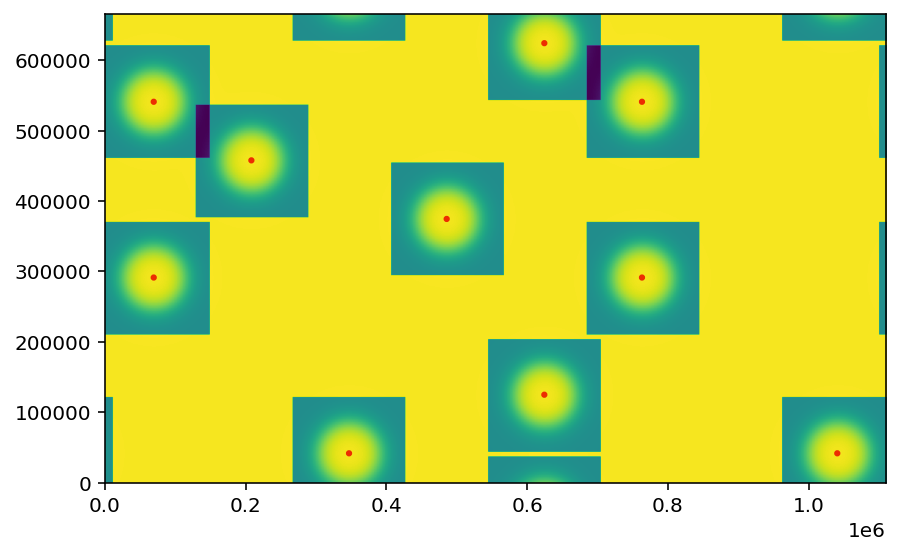

In [ ]:
plotDrifters(observations, truth_reader, t_spinup, drifter_set, dist_field_all)
plotDrifters(observations, truth_reader, t_spinup, drifter_set, box_field_all)
plotDrifters(observations, truth_reader, t_spinup, drifter_set, dist_field_all-box_field_all)

(343, 131)
500 300
307 379 95 167
[(307, 379)]
[(95, 167)]
(300, 500)


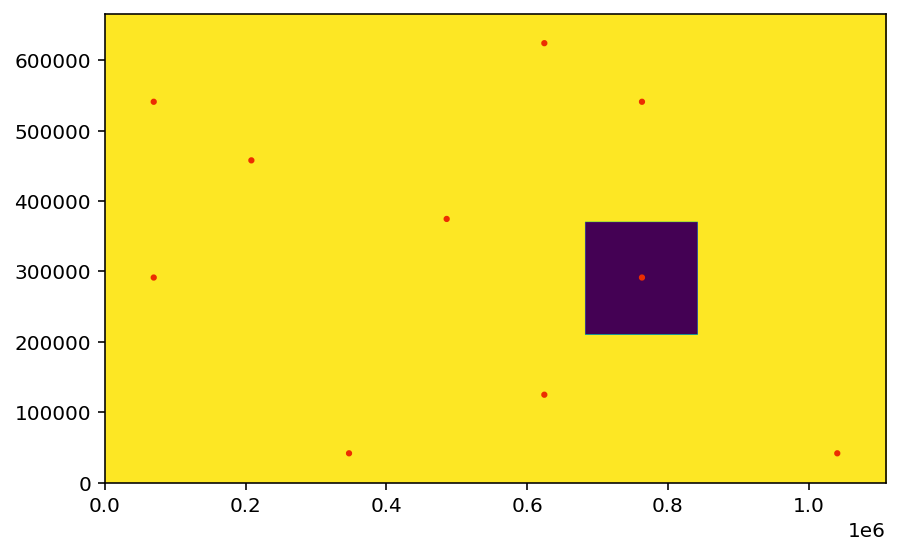

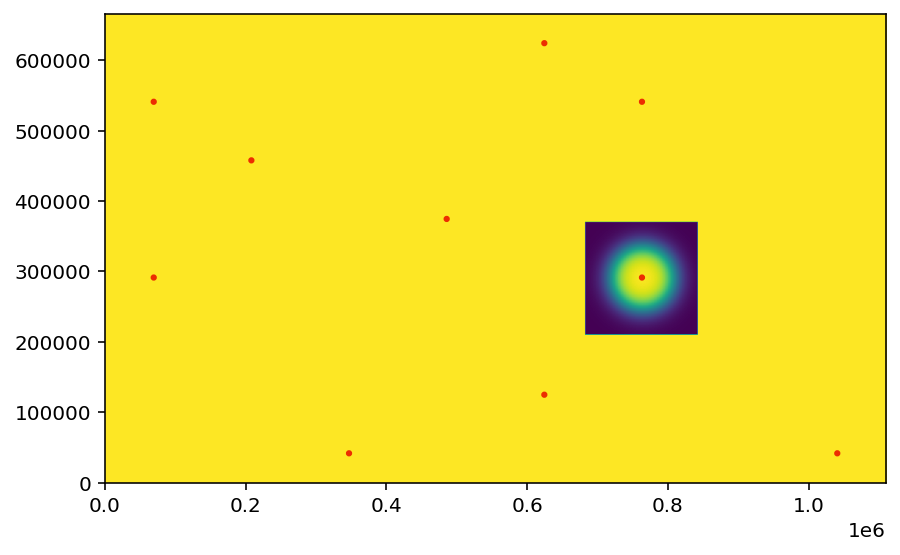

In [ ]:
def getLocalIndices(obs_locs, boxed_r, scale_r, scale_slope, dx, dy, nx, ny):
    
    localIndices = np.array([[False]*nx]*ny)
    scales = np.zeros((ny,nx))
    
    if np.isscalar(obs_locs):
        obs_locs = [obs_locs]
    
    for obs_loc in obs_locs:
        obs_loc_cellID = (np.int(obs_loc[0]//dx), np.int(obs_loc[1]//dy))

        print(obs_loc_cellID)
        loc_cell_left  = np.int((obs_loc[0]-boxed_r)//dx)
        loc_cell_right = np.int((obs_loc[0]+boxed_r)//dx)
        loc_cell_down  = np.int((obs_loc[1]-boxed_r)//dy)
        loc_cell_up    = np.int((obs_loc[1]+boxed_r)//dy)

        xranges = []
        yranges = []

        if loc_cell_left < 0:
            xranges.append((nx+loc_cell_left, nx))
            loc_cell_left = 0
        elif loc_cell_right > nx:
            xranges.append((0, loc_cell_right - nx))
            loc_cell_right = nx
        xranges.append((loc_cell_left, loc_cell_right))

        if loc_cell_down < 0:
            yranges.append((ny+loc_cell_down, ny))
            loc_cell_down = 0
        elif loc_cell_up > ny:
            yranges.append((0, loc_cell_up - ny))
            loc_cell_up = ny
        yranges.append((loc_cell_down, loc_cell_up))


        print(nx, ny)
        print(loc_cell_left, loc_cell_right, loc_cell_down, loc_cell_up)
        print(xranges)
        print(yranges)

        print(localIndices.shape)
        for xrange in xranges:
            for yrange in yranges:
                localIndices[yrange[0]:yrange[1], xrange[0]:xrange[1]] = True
                
                for y in range(yrange[0],yrange[1]):
                    for x in range(xrange[0], xrange[1]):
                        loc = np.array([(x+0.5)*dx, (y+0.5)*dy])
                        scales[y,x] = min(1, scales[y,x] + dist(obs_loc, loc, scale_r, scale_slope, nx*dx, ny*dy))
                        
        
    return localIndices, scales
        
localIndices, scales = getLocalIndices([drifter_positions[drifter_set[4],:]], dx*((r_factor/2)+drop_factor)*2, 
                               r_factor*dx, drop_factor*dx, dx, dy, nx, ny)

plotDrifters(observations, truth_reader, t_spinup, drifter_set, -localIndices.astype(np.int))
plotDrifters(observations, truth_reader, t_spinup, drifter_set, -localIndices.astype(np.int)+scales)



# More efficient local decomposition
* Check pairs with overlapping boxes
* Get local domain from x and y ranges
* Compute localization scale factor $\sigma$ for local indices only

For each local domain:
* Compute the LETKF analysis
$$ \hat{X}^a = \bar{X}^f + X^f W $$
* Relax the LETKF analysis against the forecast
$$ X^a = \sigma \hat{X}^a + (I - \sigma)X^f $$

Processing local group of drifters:  [0]
(156, 18)
500 300
120 192 0 54
[(120, 192)]
[(282, 300), (0, 54)]
(300, 500)
num local cells:  5184
Processing local group of drifters:  [1]
(468, 18)
500 300
432 500 0 54
[(0, 4), (432, 500)]
[(282, 300), (0, 54)]
(300, 500)
num local cells:  5184
Processing local group of drifters:  [2]
(281, 56)
500 300
245 317 20 92
[(245, 317)]
[(20, 92)]
(300, 500)
num local cells:  5184
Processing local group of drifters:  [3]
(31, 131)
500 300
0 67 95 167
[(495, 500), (0, 67)]
[(95, 167)]
(300, 500)
num local cells:  5184
Processing local group of drifters:  [4]
(343, 131)
500 300
307 379 95 167
[(307, 379)]
[(95, 167)]
(300, 500)
num local cells:  5184
Processing local group of drifters:  [5]
(218, 168)
500 300
182 254 132 204
[(182, 254)]
[(132, 204)]
(300, 500)
num local cells:  5184
Processing local group of drifters:  [6, 7]
(93, 206)
500 300
57 129 170 242
[(57, 129)]
[(170, 242)]
(300, 500)
(31, 243)
500 300
0 67 207 279
[(495, 500), (0, 67)]
[(20

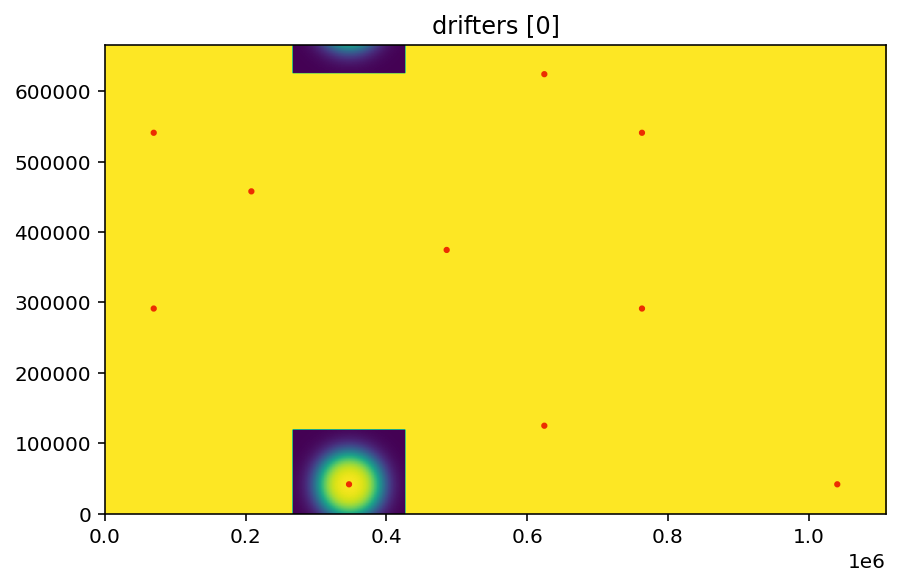

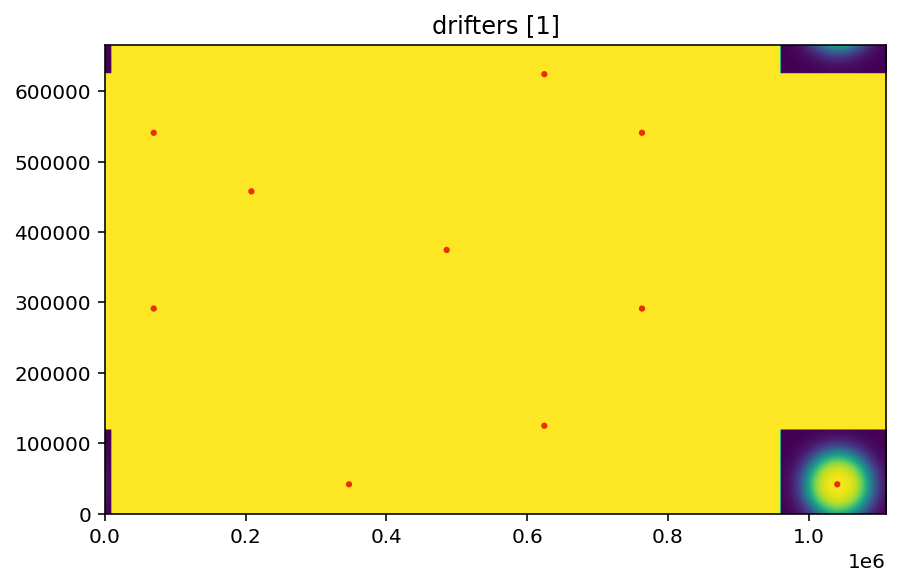

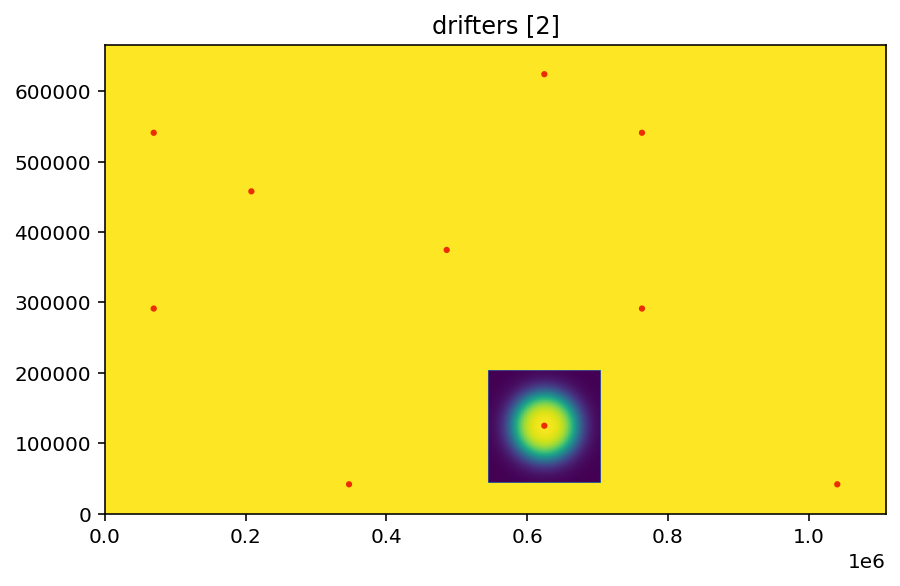

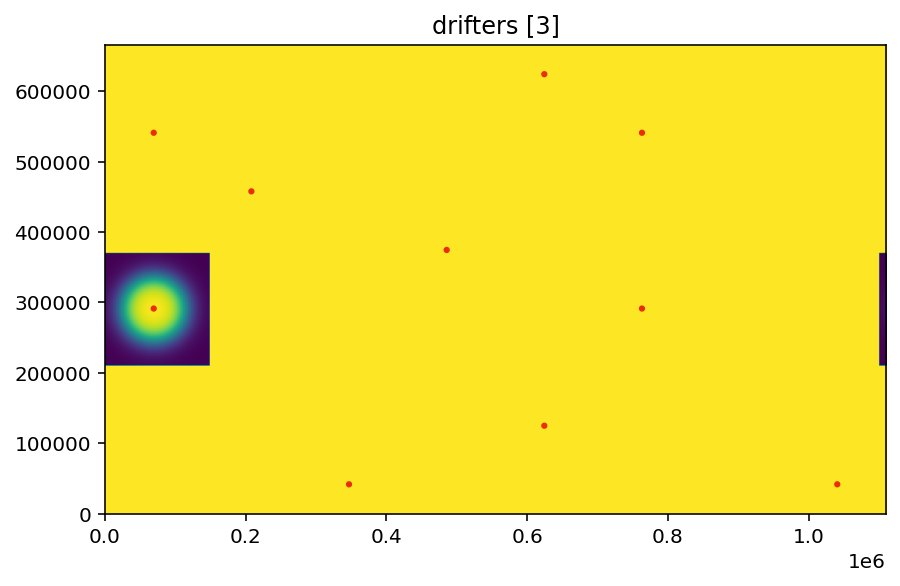

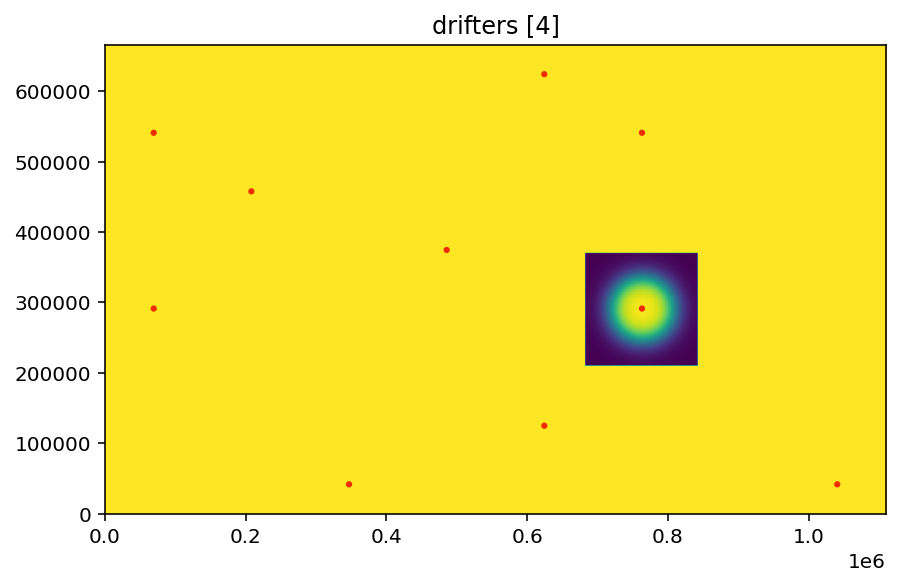

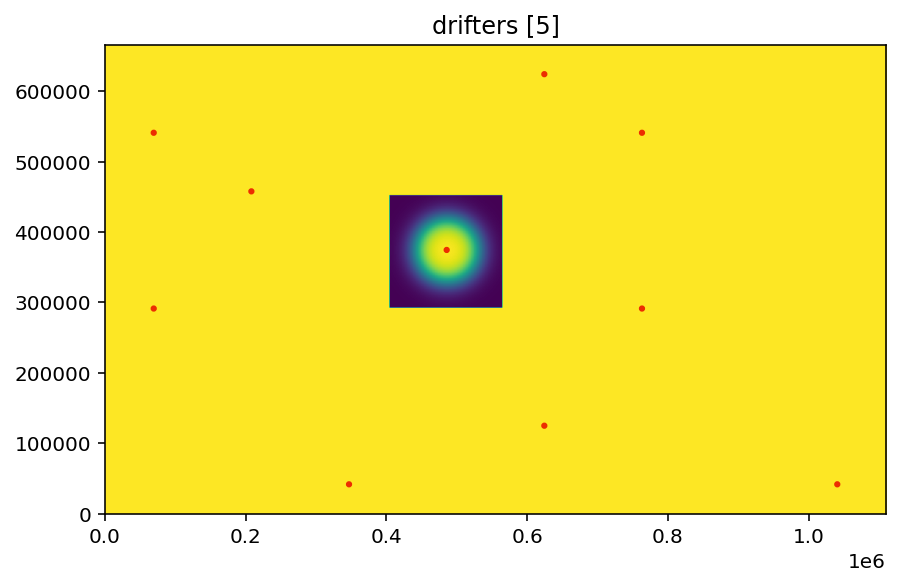

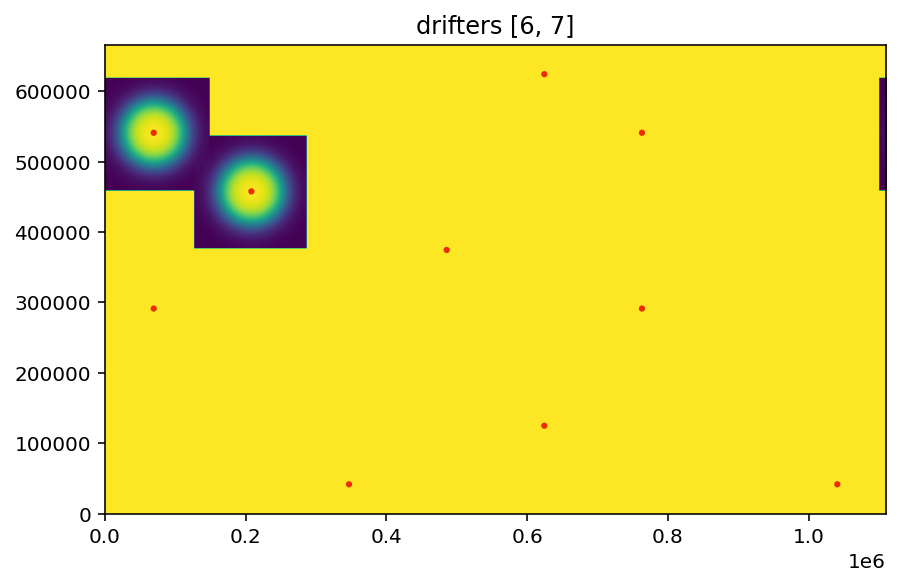

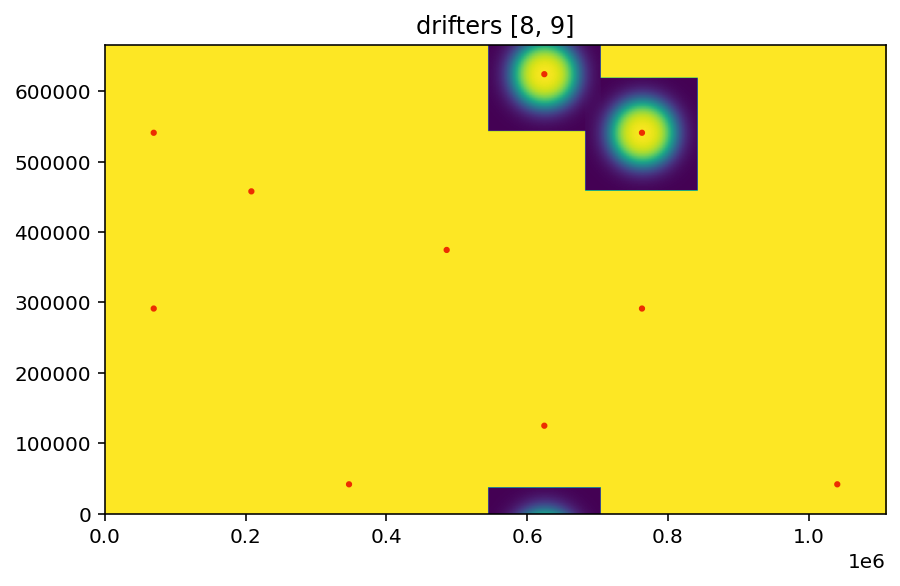

In [ ]:
obs_positions = drifter_positions[drifter_set,:]
dx, dy = truth_reader.get('dx'), truth_reader.get('dy')
nx, ny = truth_reader.get('nx'), truth_reader.get('ny')
lx, ly = nx*dx, ny*dy

numDrifters = obs_positions.shape[0]

# Compute boxed distance between drifters
distance_between_drifters = np.zeros((numDrifters, numDrifters))
for i in range(0, numDrifters):
    for j in range(i+1, numDrifters):
        distance_between_drifters[j, i] = boxDist(obs_positions[i,:], obs_positions[j,:], lx, ly)
        
# Keep track of processed drifters
processed_drifters = np.array([False]*numDrifters)
same_group_cutoff_distance = dx*((r_factor/2)+drop_factor)*4


# Group drifters and make local group for LETKF
for d in range(numDrifters):
    if processed_drifters[d]:
        print('     drifter '+str(d)+' already assimilated. Carry on')
        continue
    
    processed_drifters[d] = True
    local_drifters = [d]
    local_drifter_positions = [obs_positions[d,:]]
    for extra_d in range(d+1, numDrifters):
        if processed_drifters[extra_d]:
            continue
        if distance_between_drifters[extra_d, d] < same_group_cutoff_distance:
            local_drifters.append(extra_d)
            local_drifter_positions.append(obs_positions[extra_d, :])
            processed_drifters[extra_d] = True
    
    print("Processing local group of drifters: ", local_drifters)
    

    localIndices, scales = getLocalIndices(local_drifter_positions, same_group_cutoff_distance/2, 
                                           r_factor*dx, drop_factor*dx, dx, dy, nx, ny)

    # Plot the local areas with the scales:
    plotDrifters(observations, truth_reader, t_spinup, drifter_set, -localIndices.astype(np.int)+scales)
    plt.title('drifters ' + str(local_drifters))
    print('num local cells: ', np.sum(localIndices))       
        
    # Now, we can create the forecast
    # xf = [eta(localIndices), hu(localIndices), hv(localIndices)]
    # carry out the LETKF to get xa for localIndices
    # eta[localIndices] = np.flatten(scales)*xa + (1-np.flatten(scales)*xf)

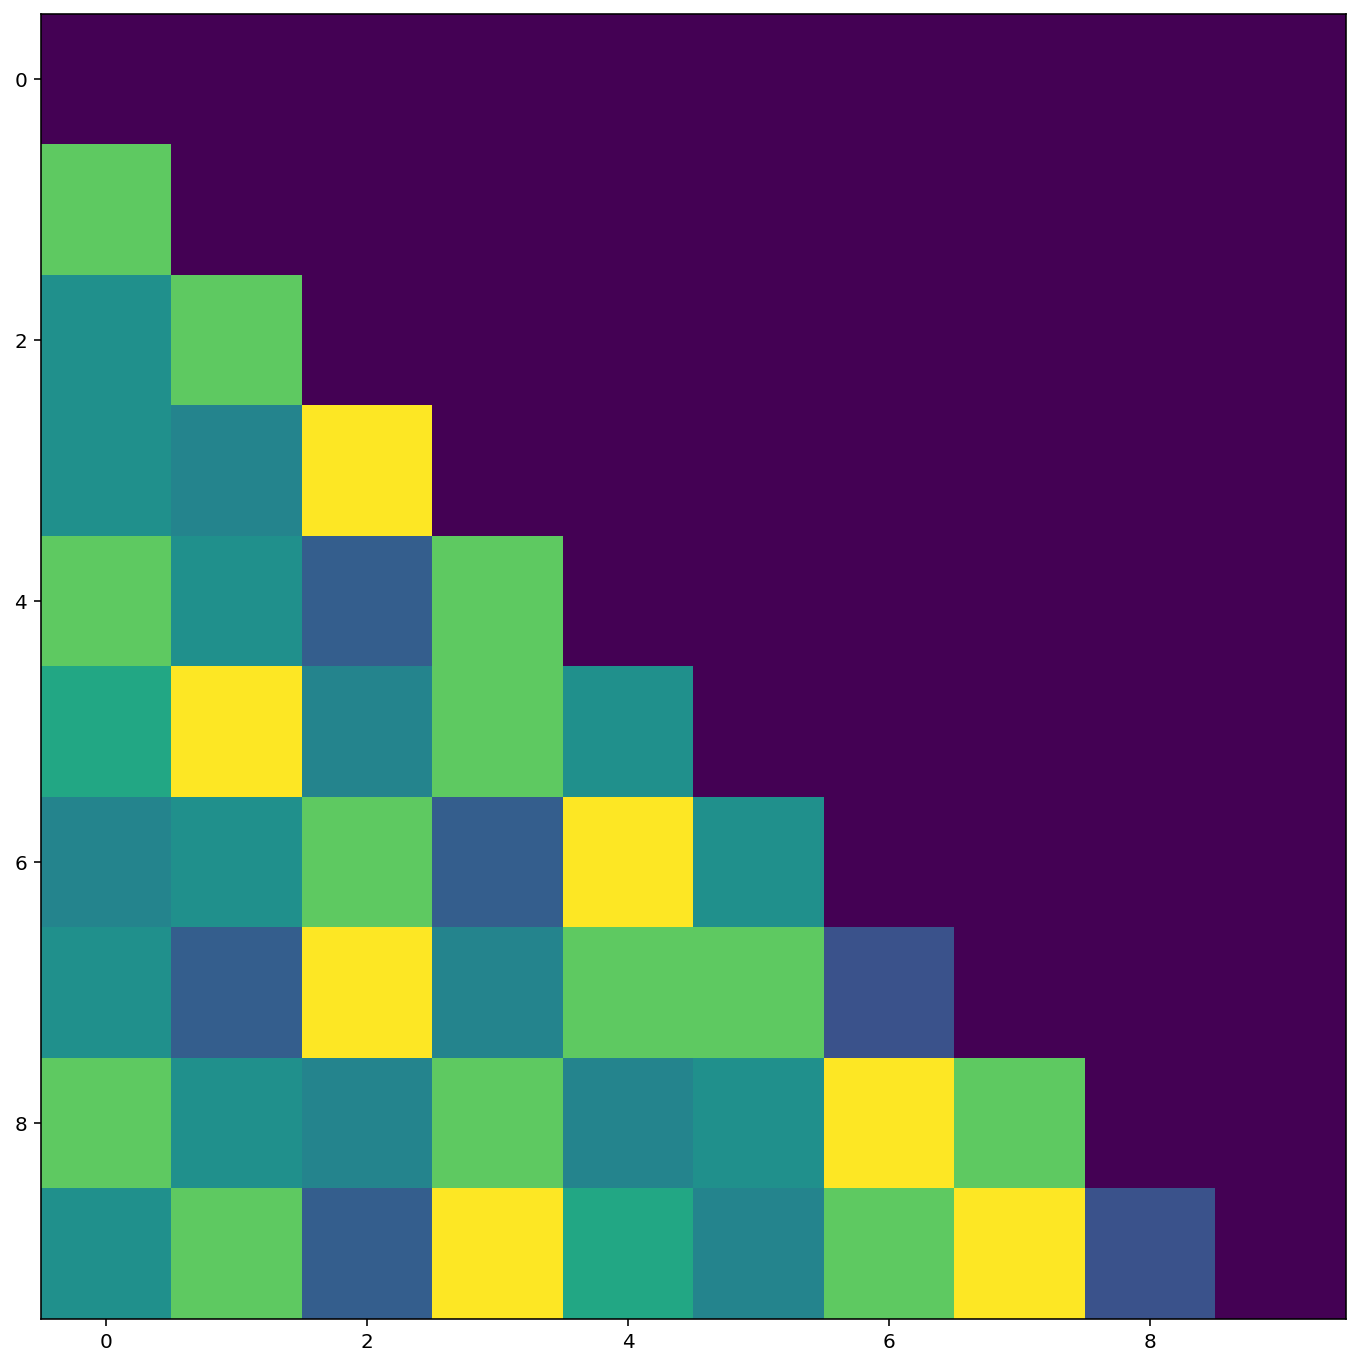

In [ ]:
plt.imshow(distance_between_drifters)